# Colley Sport Ranking

In [1]:
import pandas as pd
import numpy as np

In [2]:
fixtures = pd.read_csv('../data/fpl_official/vaastav/data/2021-22/fixtures.csv')

results = fixtures[fixtures['finished'] == True][['team_a', 'team_a_score', 'team_h', 'team_h_score']]

league_table = pd.read_csv('../data/fpl_official/vaastav/data/2021-22/teams.csv')[['id', 'name', 'short_name']]

In [3]:
league_table = league_table.replace({
    'Brighton': 'Brighton and Hove Albion',
    'Leicester': 'Leicester City',
    'Leeds': 'Leeds United',
    'Man City': 'Manchester City',
    'Man Utd': 'Manchester United',
    'Norwich': 'Norwich City',
    'Spurs': 'Tottenham Hotspur',
    'West Ham': 'West Ham United',
    'Wolves': 'Wolverhampton'
})

In [4]:
def score_to_points_at_home(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] < row['team_h_score']:
        return 3
    else:
        return 0

home_results = results.copy()
home_results['res'] = home_results.apply(lambda row: score_to_points_at_home(row), axis=1)
home_results = (home_results.loc[:, ['team_a', 'team_h', 'res']])

In [5]:
def score_to_points_at_away(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] > row['team_h_score']:
        return 3
    else:
        return 0

away_results = results.copy()
away_results['res'] = away_results.apply(lambda row: score_to_points_at_away(row), axis=1)
away_results = (away_results.loc[:, ['team_a', 'team_h', 'res']])

In [6]:
def aggregate_res(team):
    return (
        sum(home_results[home_results['team_h'] == team]['res'] == 3) +
        sum(away_results[away_results['team_a'] == team]['res'] == 3) +
        0.5 * (
            sum(home_results[home_results['team_h'] == team]['res'] == 3) -
            sum(home_results[home_results['team_h'] == team]['res'] == 0) +
            sum(away_results[away_results['team_a'] == team]['res'] == 3) -
            sum(away_results[away_results['team_a'] == team]['res'] == 0)
            )
        )

In [7]:
lt = (league_table.id.map(aggregate_res))
league_table['res'] = lt
league_table.sort_values(by=['res'], ascending=False)

,id,name,short_name,res
5,6,Chelsea,CHE,11.5
10,11,Liverpool,LIV,9.0
18,19,West Ham United,WHU,8.0
11,12,Manchester City,MCI,8.0
12,13,Manchester United,MUN,6.0
0,1,Arsenal,ARS,6.0
19,20,Wolverhampton,WOL,5.5
3,4,Brighton and Hove Albion,BHA,5.0
16,17,Tottenham Hotspur,TOT,5.0
7,8,Everton,EVE,4.0


In [8]:
x = pd.DataFrame(
    index=league_table["id"],
    columns=league_table["id"]).fillna(0)

In [9]:
for i in range(1, 21):
    x.loc[i, i] = 2

for _, row in results.iterrows():
    x.loc[int(row['team_h']), int(row['team_h'])] += 1
    x.loc[int(row['team_h']), int(row['team_a'])] = -1
    
    x.loc[int(row['team_a']), int(row['team_a'])] += 1
    x.loc[int(row['team_a']), int(row['team_h'])] = -1

X = x.values

y = league_table['res'].values

In [10]:
# Solve y = Xr
league_table['colley'] = np.linalg.inv(X) @ y
league_table = league_table.sort_values('colley')

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

In [12]:
logos = {
    # https://www.transfermarkt.com/premier-league/transfers/wettbewerb/GB1
    'Arsenal': '../data/logos/ARS.png',
    'Aston Villa': '../data/logos/AVL.png',
    'Brighton and Hove Albion': '../data/logos/BHA.png',
    'Brentford': '../data/logos/BRE.png',
    'Burnley': '../data/logos/BUR.png',
    'Chelsea': '../data/logos/CHE.png',
    'Crystal Palace': '../data/logos/CRY.png',
    'Everton': '../data/logos/EVE.png',
    'Leicester City': '../data/logos/LEI.png',
    'Leeds United': '../data/logos/LEE.png',
    'Liverpool': '../data/logos/LIV.png',
    'Manchester City': '../data/logos/MCI.png',
    'Manchester United': '../data/logos/MUN.png',
    'Norwich City': '../data/logos/NOR.png',
    'Newcastle': '../data/logos/NEW.png',
    'Southampton': '../data/logos/SOU.png',
    'Tottenham Hotspur': '../data/logos/TOT.png',
    'Watford': '../data/logos/WAT.png',
    'West Ham United': '../data/logos/WHU.png',
    'Wolverhampton': '../data/logos/WOL.png',
}

In [13]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def get_logo(name):
    return plt.imread(logos[name])

def offset_image(coord, name, ax):
    img = get_logo(name)
    im = OffsetImage(img, zoom=0.20)
    im.image.axes = ax

    ab = AnnotationBbox(im, (-0.05, (coord+1.3)/(21.7)), frameon=False, xycoords='axes fraction')

    ax.add_artist(ab)

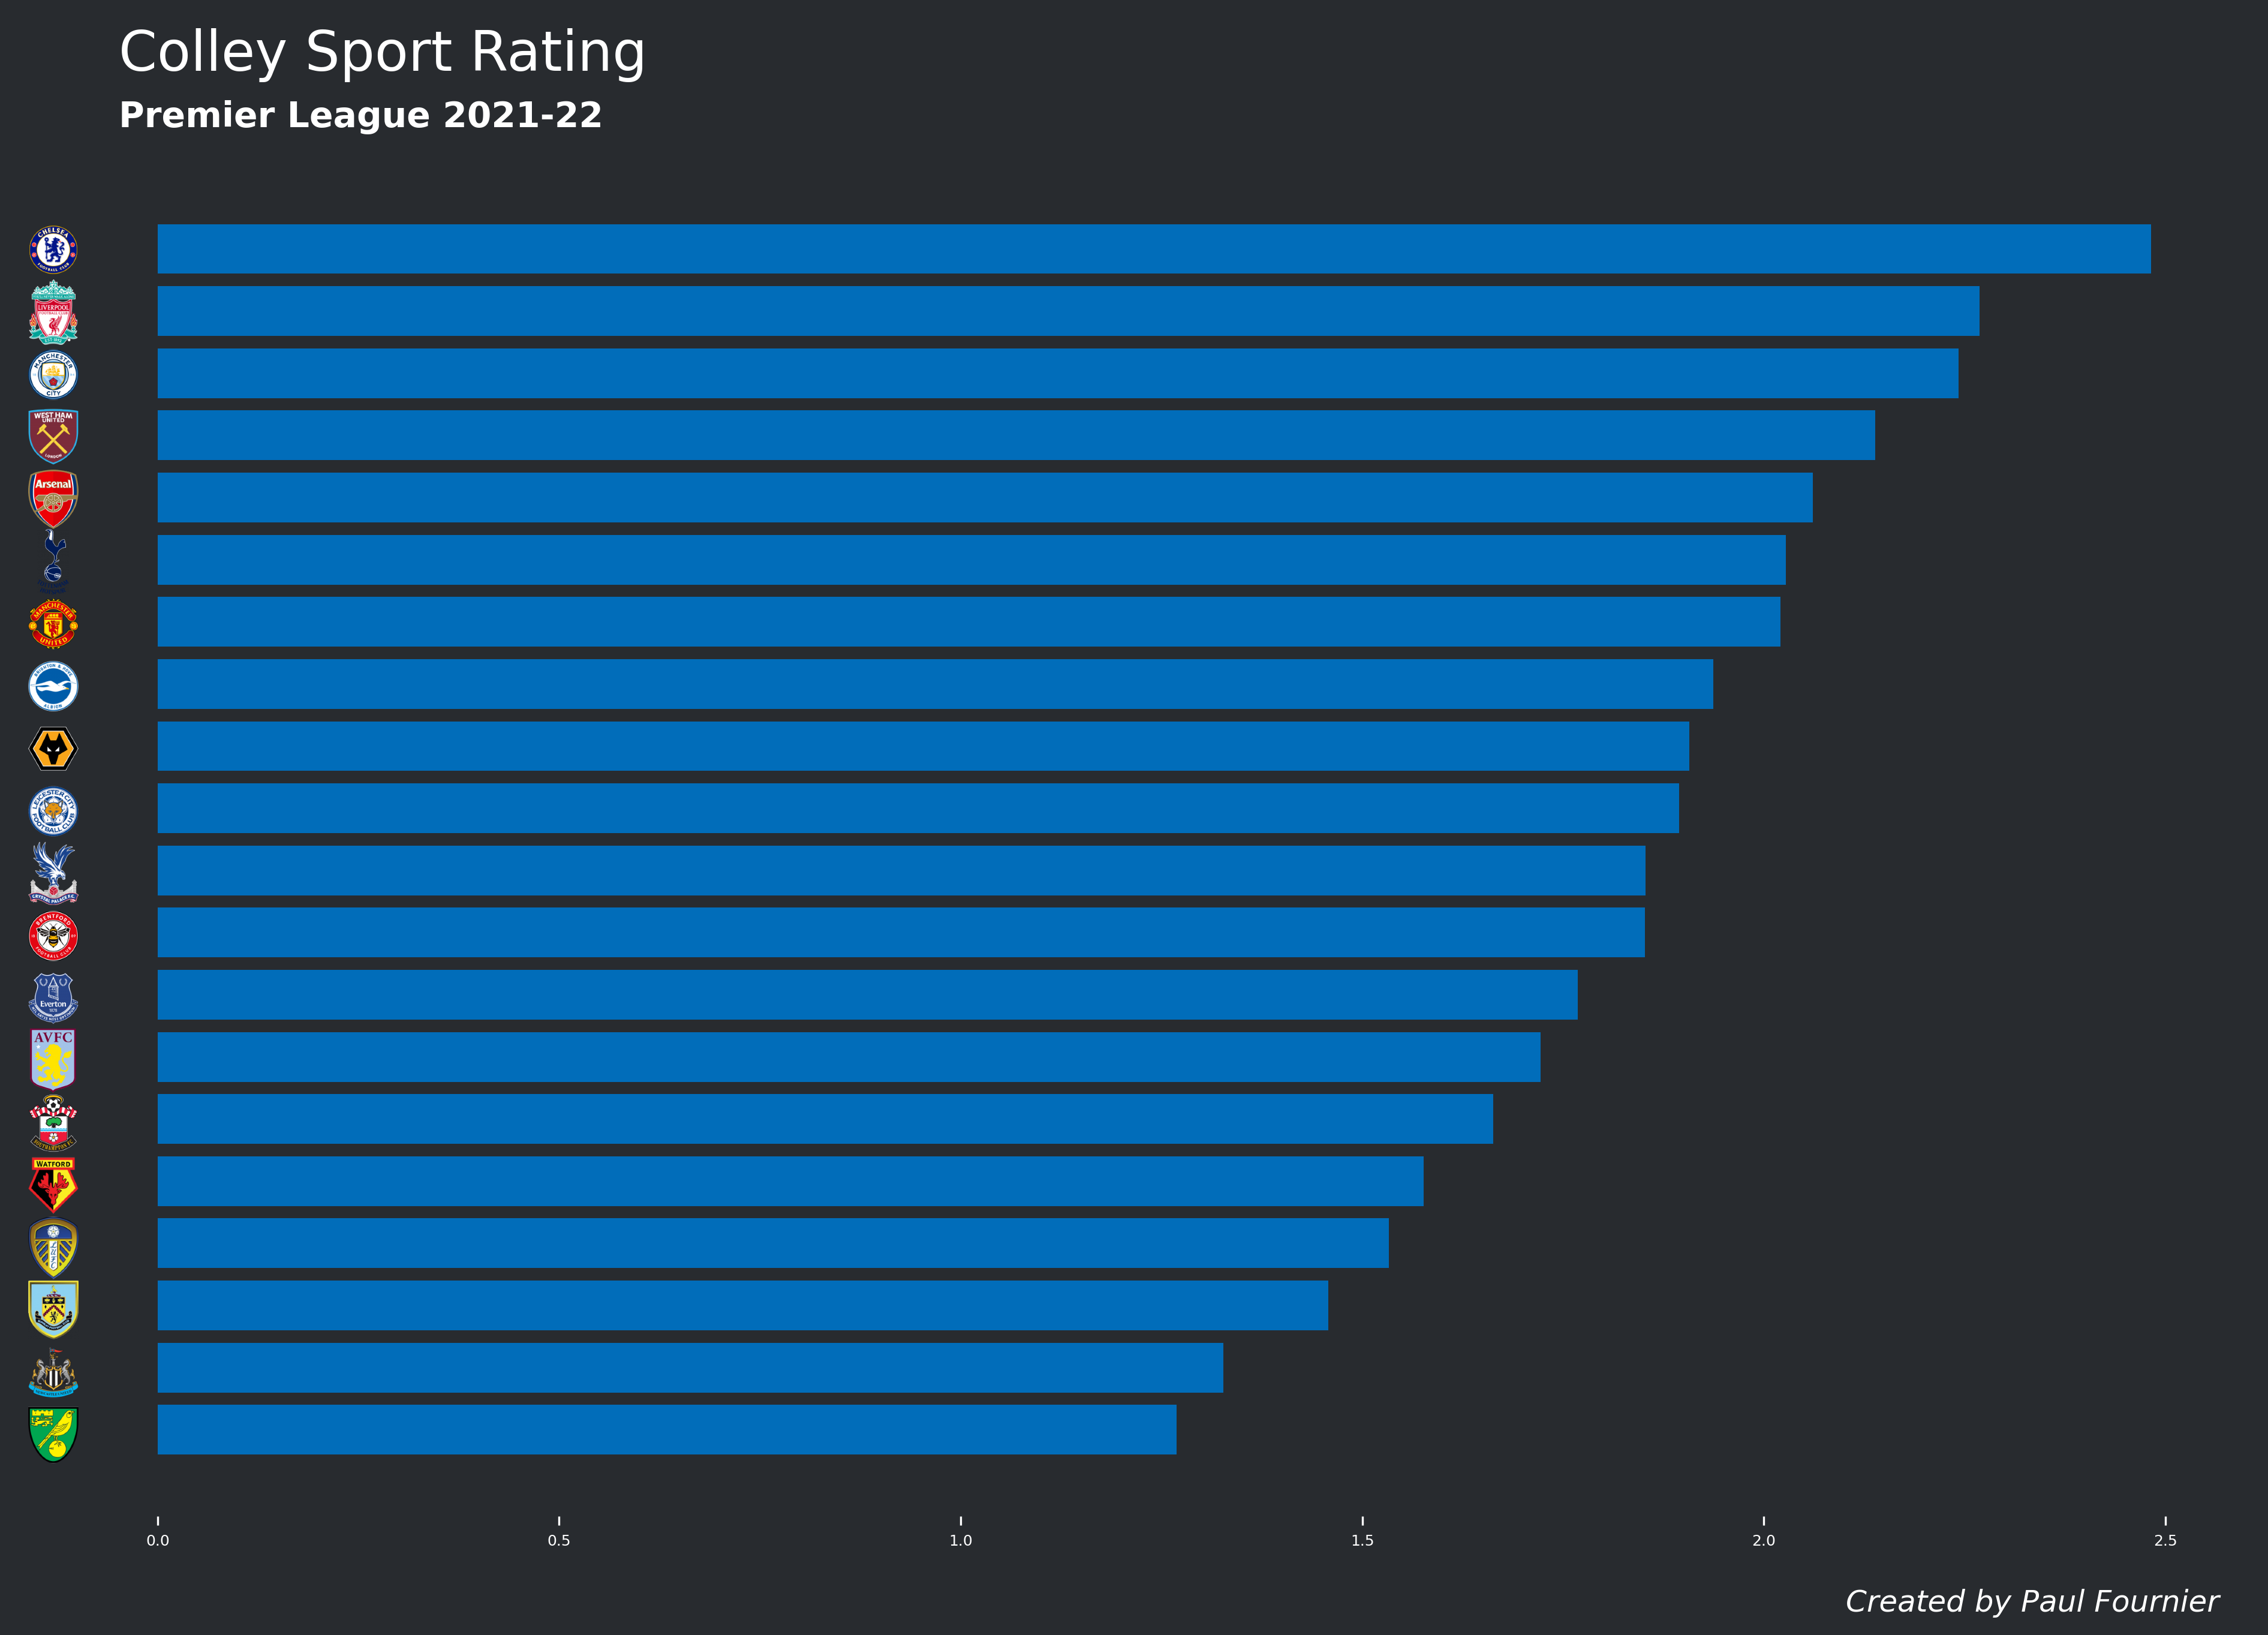

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

for i, c in enumerate(league_table['name']):
    offset_image(i, c, ax)

ax.barh(
    league_table['name'],
    league_table['colley'],
    color="#016DBA")
    
ax.get_yaxis().set_visible(False)
plt.box(on=None)

fig_text(x=0., y=1.075,
        s="Colley Sport Rating",
        fontweight="regular", fontsize=22, fontfamily=title_font,
        color=text_color, alpha=1)

fig_text(x=0., y=1.025,
        s="Premier League 2021-22",
        fontweight="bold", fontsize=14, fontfamily=title_font,
        color=text_color, alpha=1)

fig.text(
    0.8, -0.025, "Created by Paul Fournier", fontstyle="italic",
    fontsize=12, fontfamily=watermark_font, color=text_color)

plt.tight_layout()
plt.show()

## Weights

In [15]:
def time_decay(xi, t):
    return np.exp(-xi * t)

results = fixtures[fixtures['finished'] == True][['team_a', 'team_a_score', 'team_h', 'team_h_score', 'kickoff_time']]
results["date"] = pd.to_datetime(results["kickoff_time"])
results["days_since"] = (results["date"].max() - results["date"]).dt.days
results["weight"] = time_decay(0.001, results["days_since"])

In [16]:
home_results = results.copy()
home_results['res'] = home_results.apply(lambda row: score_to_points_at_home(row), axis=1)
home_results = (home_results.loc[:, ['team_a', 'team_h', 'res', 'weight']])

In [17]:
away_results = results.copy()
away_results['res'] = away_results.apply(lambda row: score_to_points_at_away(row), axis=1)
away_results = (away_results.loc[:, ['team_a', 'team_h', 'res', 'weight']])

In [18]:
def aggregate_res(team):
    return (
        sum((home_results[home_results['team_h'] == team]['res'] == 3) * home_results[home_results['team_h'] == team]['weight']) +
        sum((away_results[away_results['team_a'] == team]['res'] == 3) * away_results[away_results['team_a'] == team]['weight']) +
        0.5 * (
            sum((home_results[home_results['team_h'] == team]['res'] == 3) * home_results[home_results['team_h'] == team]['weight']) -
            sum((home_results[home_results['team_h'] == team]['res'] == 0) * home_results[home_results['team_h'] == team]['weight']) +
            sum((away_results[away_results['team_a'] == team]['res'] == 3) * away_results[away_results['team_a'] == team]['weight']) -
            sum((away_results[away_results['team_a'] == team]['res'] == 0) * away_results[away_results['team_a'] == team]['weight'])
            )
        )

In [19]:
lt = (league_table.id.map(aggregate_res))
league_table['res'] = lt

In [20]:
x = pd.DataFrame(
    index=league_table["id"],
    columns=league_table["id"]).fillna(0)

In [21]:
for i in range(1, 21):
    x.loc[i, i] = 2

for _, row in results.iterrows():
    x.loc[int(row['team_h']), int(row['team_h'])] += row['weight']
    x.loc[int(row['team_h']), int(row['team_a'])] = -row['weight']
    
    x.loc[int(row['team_a']), int(row['team_a'])] += row['weight']
    x.loc[int(row['team_a']), int(row['team_h'])] = -row['weight']

X = x.values

y = league_table['res'].values

In [22]:
# Solve y = Xr
league_table['colley'] = np.linalg.inv(X) @ y
league_table = league_table.sort_values('colley')

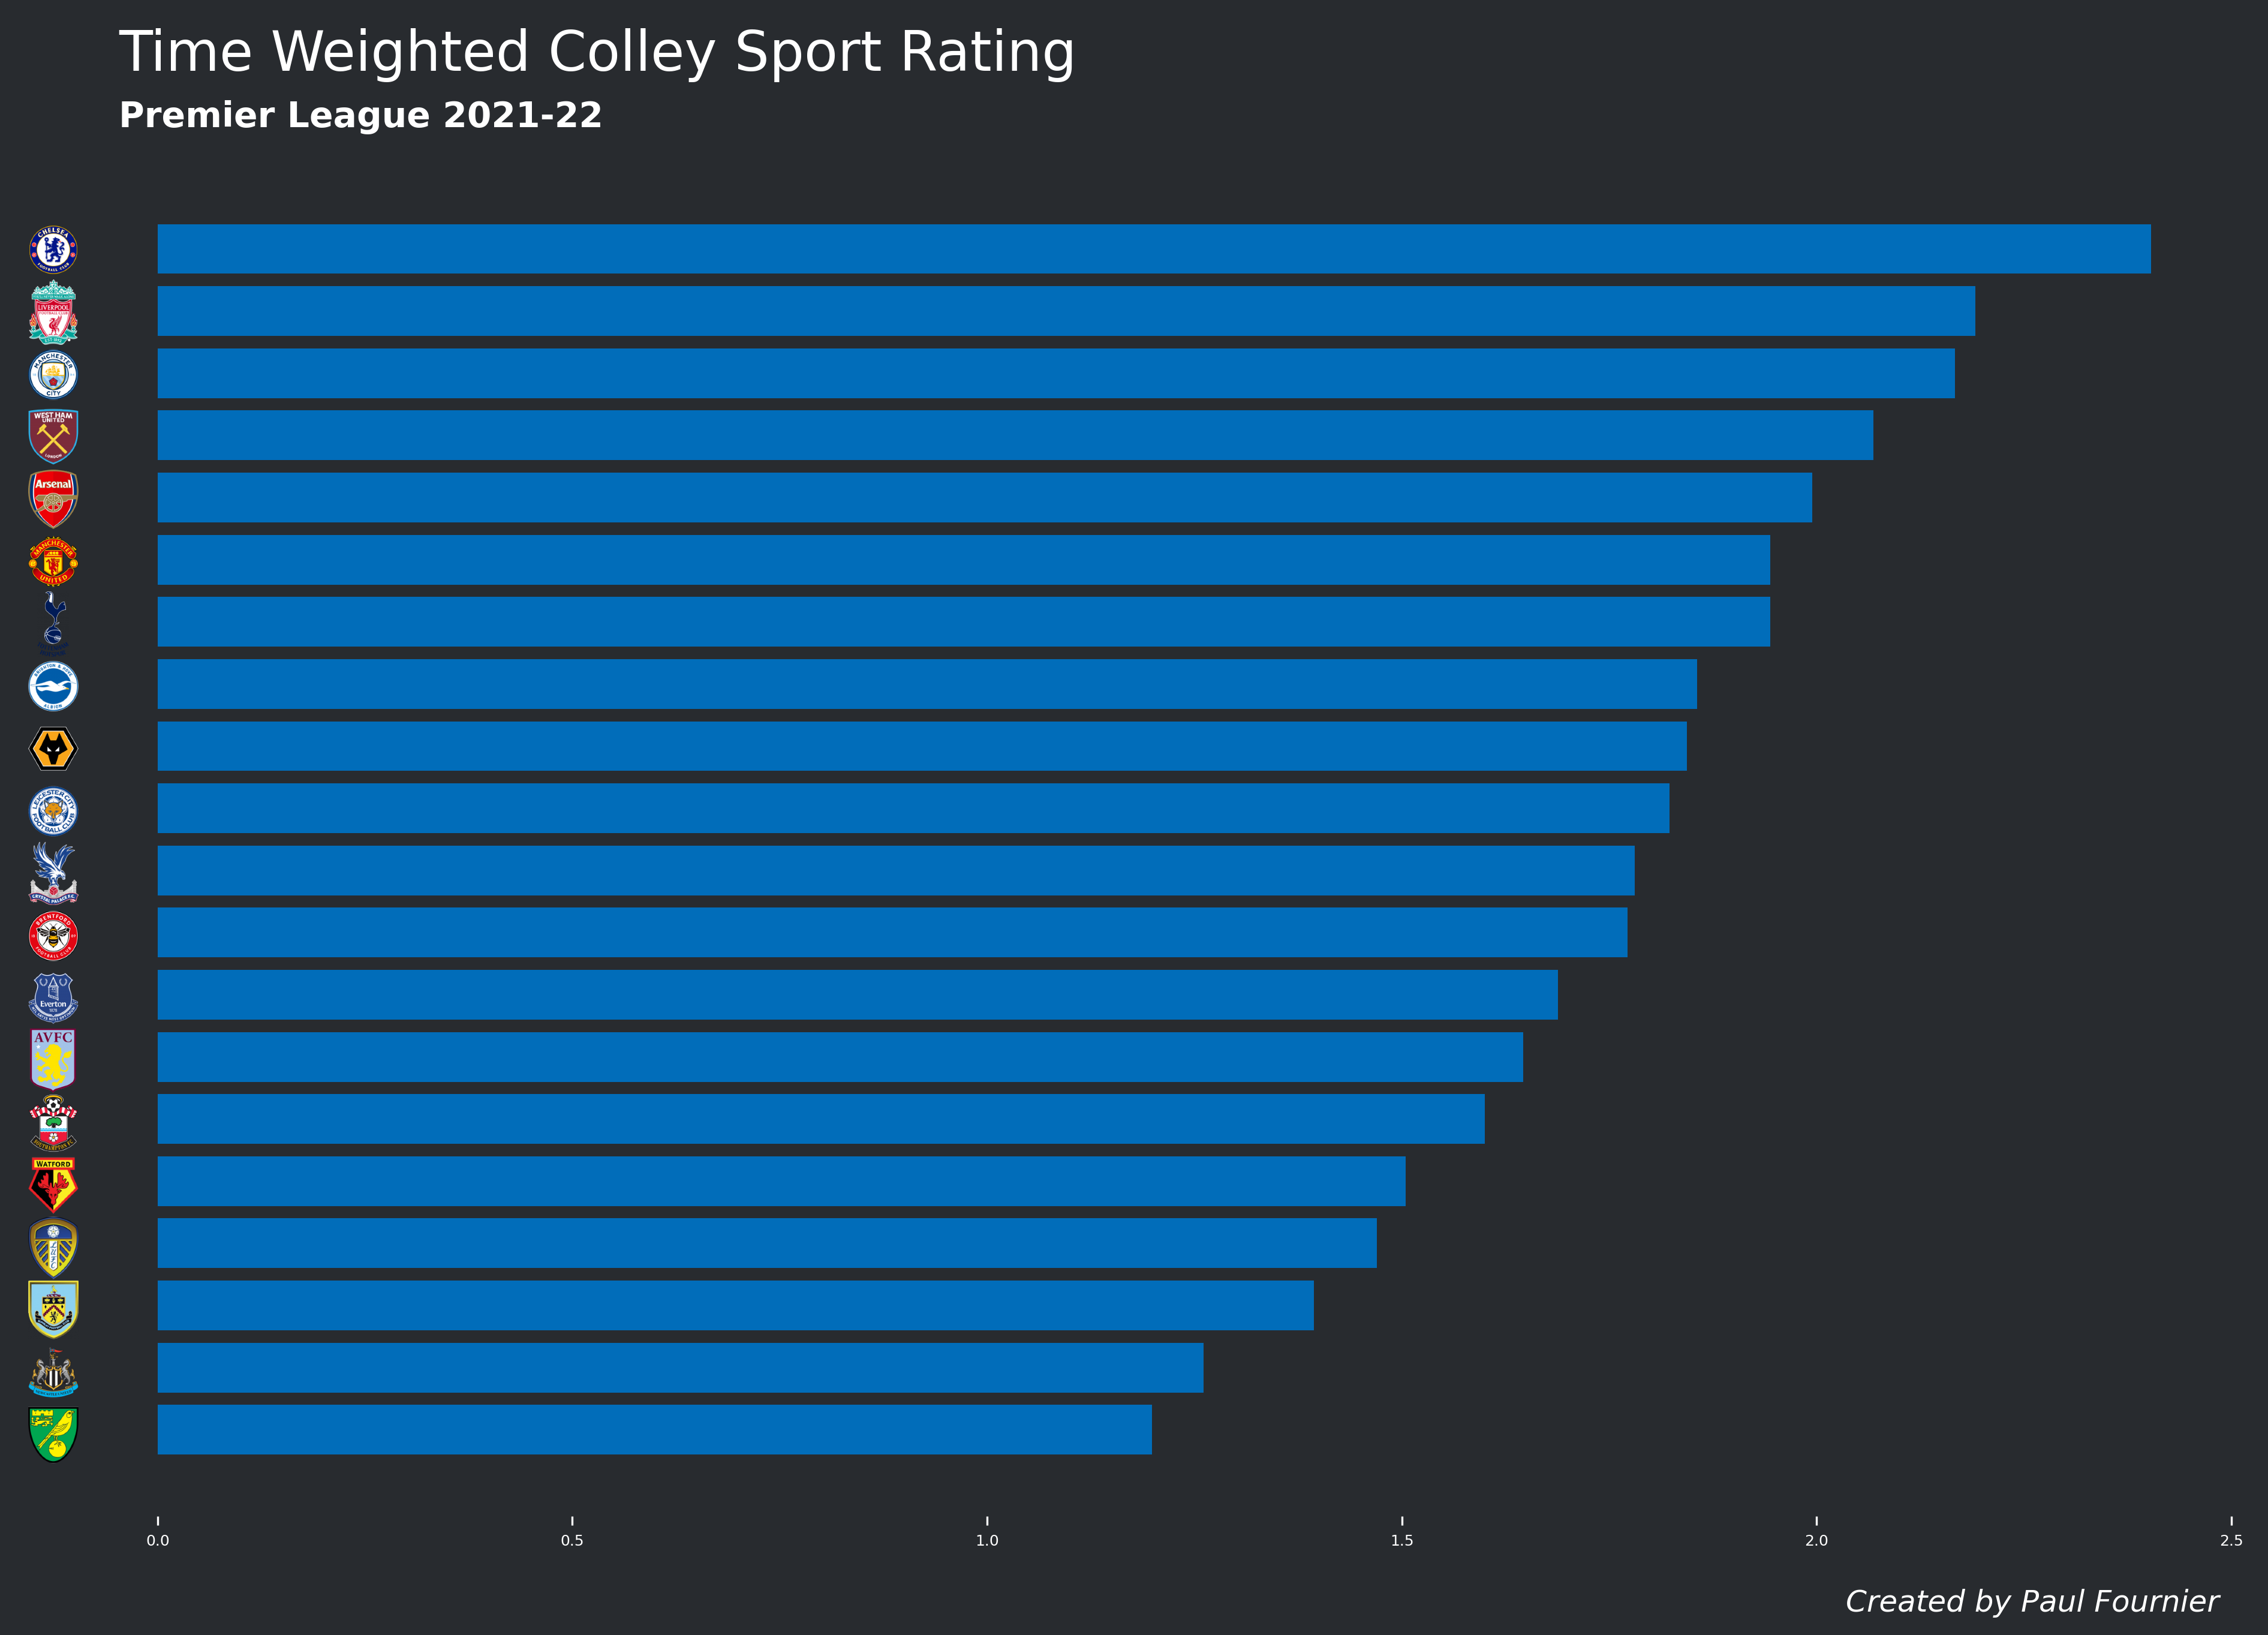

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

for i, c in enumerate(league_table['name']):
    offset_image(i, c, ax)

ax.barh(
    league_table['name'],
    league_table['colley'],
    color="#016DBA")
    
ax.get_yaxis().set_visible(False)
plt.box(on=None)

fig_text(x=0., y=1.075,
        s="Time Weighted Colley Sport Rating",
        fontweight="regular", fontsize=22, fontfamily=title_font,
        color=text_color, alpha=1)

fig_text(x=0., y=1.025,
        s="Premier League 2021-22",
        fontweight="bold", fontsize=14, fontfamily=title_font,
        color=text_color, alpha=1)

fig.text(
    0.8, -0.025, "Created by Paul Fournier", fontstyle="italic",
    fontsize=12, fontfamily=watermark_font, color=text_color)

plt.tight_layout()
plt.show()